# Microbiome Sonification Experiments

This notebook guides you through microbiome data visualisation and sonification in the R programming language. We will explore an open microbiome dataset using the mia package for microbiome data analysis.

In the past, R had a very nice package for data sonification called playitbyr, which was using the same syntax as the famous ggplot2 package designed for data visualisation. Unfortunately, playitbyr is no longer maintained, so we will have to use the lower-level sonify package. To see (or hear) what playitbyr was capable of, go to [this address](http://playitbyr.org/).

Fun fact: ggplot2 is what most R programmers use to make publication-ready figures!

## System Setup

If you are running this notebook on Google Collab, you will need to run the code chunk below to install the necessary packages. It takes about 15 minutes.

In [1]:
# Set to 1 to install packages
install <- 0

if( install == 1 ){
    # Install sonification packages
    install.packages(c("BiocManager", "sonify", "BrailleR"))
    # Install microbiome packages
    BiocManager::install(c("mia", "miaViz", "scater"))
    # Install text-to-speech synthesiser
    system2("sudo apt-get -y install espeak-ng")
}

Once installation is complete, import the packages to get started.

In [2]:
# Import packages
suppressPackageStartupMessages({
    library(BrailleR)
    library(mia)
    library(miaViz)
    library(scater)
    library(sonify)
})

We will analyse the GlobalPatterns dataset, which includes 28 microbiome samples from either the environment or the human body. More information on this study is available at [this address](https://microbiome.github.io/mia/reference/GlobalPatterns.html).

In [16]:
# Load dataset
data("GlobalPatterns", package = "mia")
tse <- GlobalPatterns

# Make sample types compatible with espeak
tse$SampleType <- gsub("\\)", "", gsub(" \\(", "_", tse$SampleType))

The original dataset contains an abundance table with 19216 microbial features as rows and 26 samples as columns. That is pretty big, so we will agglomerate it to a higher taxonomic rank. This basically means summing up counts from closely-related bugs to end up with fewer microbial features, or rows.

In [12]:
# Transform counts to relative abundance
tse <- transformAssay(tse, method = "relabundance")

# Agglomerate by Phylum
tse <- agglomerateByPrevalence(
    tse,
    prevalence = 50/100,
    detection = 1/100,
    rank = "Phylum"
)

# Print experiment
tse

class: TreeSummarizedExperiment 
dim: 35 26 
metadata(2): agglomerated_by_rank agglomerated_by_rank
assays(2): counts relabundance
rownames(35): Acidobacteria Actinobacteria ... WS3 Other
rowData names(7): Kingdom Phylum ... Genus Species
colnames(26): CL3 CC1 ... Even2 Even3
colData names(7): X.SampleID Primer ... SampleType Description
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):
rowLinks: a LinkDataFrame (35 rows)
rowTree: 1 phylo tree(s) (35 leaves)
colLinks: NULL
colTree: NULL

## Bacterial Abundance

This chart has title 'Composition Barplot'.
It has x-axis 'Samples' with labels Feces, Freshwater, Freshwater_creek, Mock, Ocean, Sediment_estuary, Skin, Soil and Tongue.
It has y-axis 'Abundance' with labels 0e+00, 1e+06, 2e+06, 3e+06, 4e+06 and 5e+06.
There is a legend indicating fill is used to show colour_by, with 6 levels:
Actinobacteria shown as light blue fill, 
Bacteroidetes shown as brilliant orange fill, 
Cyanobacteria shown as brilliant yellowish green fill, 
Firmicutes shown as strong reddish orange fill, 
Other shown as light violet fill and 
Proteobacteria shown as light reddish brown fill.
There is a legend indicating colour is used to show colour_by, with 6 levels:
Actinobacteria shown as light blue colour, 
Bacteroidetes shown as brilliant orange colour, 
Cyanobacteria shown as brilliant yellowish green colour, 
Firmicutes shown as strong reddish orange colour, 
Other shown as light violet colour and 
Proteobacteria shown as light reddish brown colour.
The chart is a b

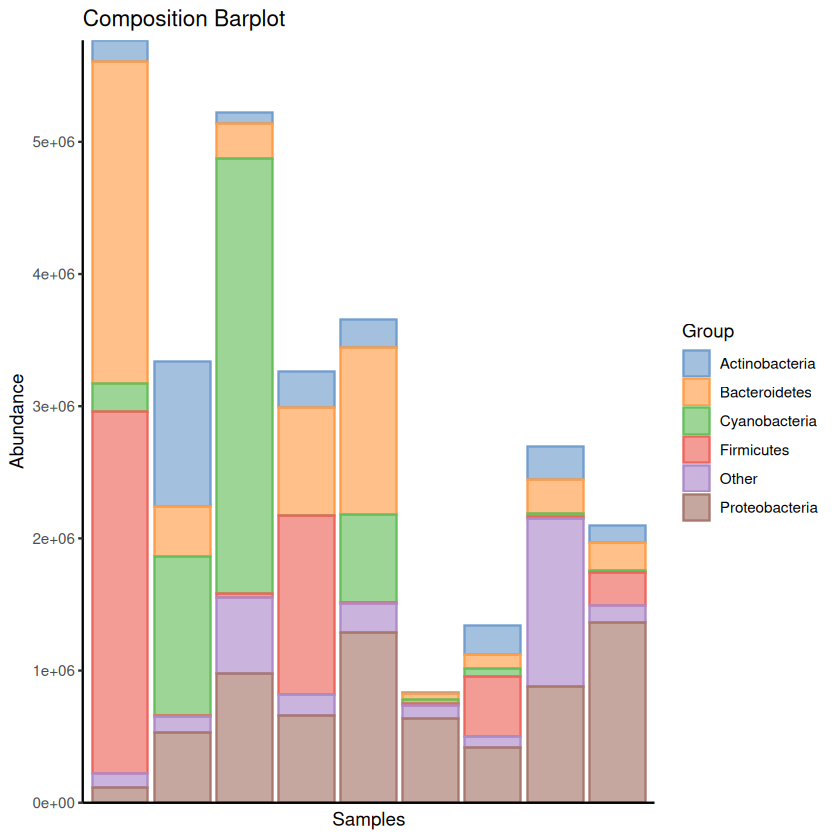

In [13]:
# Agglomerate by sample type
tse <- agglomerateByVariable(
    tse,
    by = 2L,
    group = "SampleType"
)

# Find top taxa
top_taxa <- getTop(tse)
rowData(tse)$Group <- ifelse(rowData(tse)$Phylum %in% top_taxa,
                             rowData(tse)$Phylum, "Other")

# Visualise composition barplot
p <- plotAbundance(tse, group = "Group")
p + ggtitle("Composition Barplot")

In [14]:
abund2freq <- function(abund) {
  
    norm_abund <- (abund - min(abund)) / (max(abund) - min(abund))
    freq <- 440 + norm_abund * (880 - 440)
  
    return(freq)
}

col_sums <- abund2freq(colSums(assay(tse, "counts")))

In [15]:
for( i in seq_along(col_sums) ){
  
    col_sum <- col_sums[i]
    system2("espeak-ng", args = names(col_sum))
  
    sonify(
        y = col_sum,
        waveform = "square",
        interpolation = "constant",
        flim = c(col_sum, col_sum),
        duration = 0.5,
        player = "mplayer",
    )
}

## Sample Composition

In [ ]:
tse_sub <- agglomerateByVariable(
  tse[ , tse$SampleType == "Soil"],
  by = 1L,
  group = "Group"
)

plotAbundance(tse_sub, group = "Group")

In [ ]:
soil_sums <- abund2freq(as.vector(assay(tse_sub, "counts")))
names(soil_sums) <- rownames(tse_sub)

for( i in seq_along(soil_sums) ){
    
    soil_sum <- soil_sums[i]
  
    system2("espeak-ng", args = names(soil_sum))
  
    sonify(
        y = soil_sum,
        waveform = "square",
        interpolation = "constant",
        flim = c(soil_sum, soil_sum),
        duration = 0.5,
        player = "mplayer",
    )
}

## Alpha Diversity

Warning message:
“The following values are already present in `colData` and will be overwritten: 'faith_diversity'. Consider using the 'name' argument to specify alternative names.”


This chart has title 'Alpha Diversity Boxplot'.
It has x-axis 'SampleType' with labels Feces and Soil.
It has y-axis 'faith_diversity' with labels 120, 160, 200 and 240.
There is a legend indicating colour is used to show colour_by, with 2 levels:
Feces shown as light blue colour and 
Soil shown as brilliant orange colour.
It has 2 layers.
Layer 1 is a violin graph that VI cannot process.
Layer 1 has fill set to purplish white.
Layer 1 has colour set to purplish gray.
Layer 1 has alpha set to 0.2.
Layer 2 is a set of 7 big solid circle points of which about 100% can be seen.
The points are at:
(1, 117.88) colour light blue which maps to colour_by = Feces, 
(0.8, 119.82) colour light blue which maps to colour_by = Feces, 
(0.84, 124.65) colour light blue which maps to colour_by = Feces, 
(1.17, 121.21) colour light blue which maps to colour_by = Feces, 
(1.81, 250.54) colour brilliant orange which maps to colour_by = Soil, 
(2.19, 262.26) colour brilliant orange which maps to colour_by 

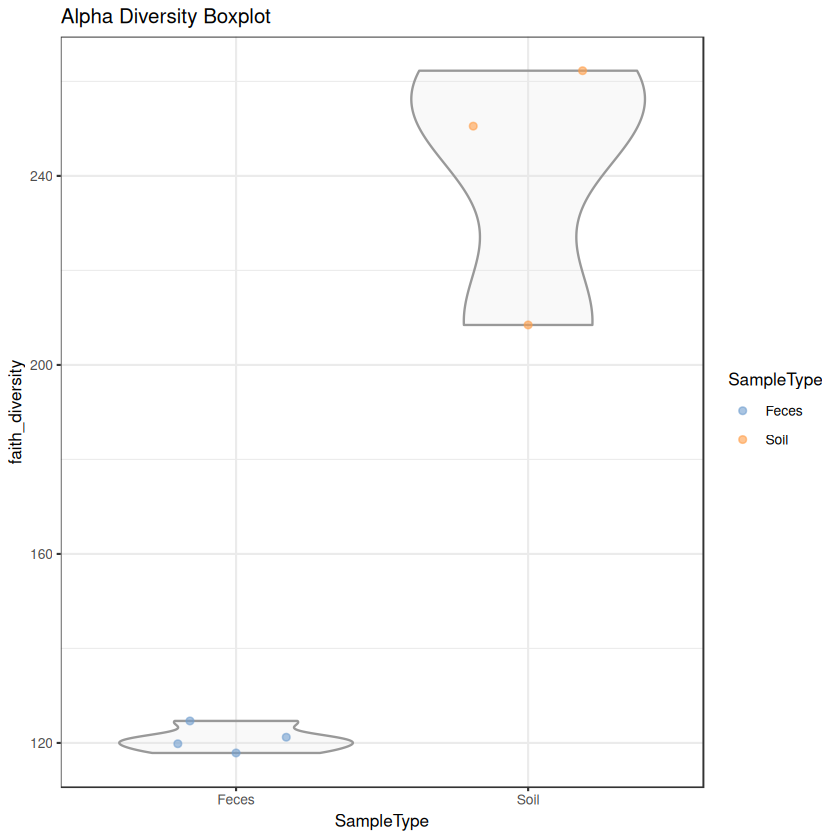

In [22]:
# Estimate alpha diversity
tse <- addAlpha(tse, index = "faith_diversity")

# Subset feces and soi  samples
tse_sub <- tse[ , tse$SampleType %in% c("Feces", "Soil")]

# Visualise alpha diversity
p <- plotColData(
    tse_sub,
    y = "faith_diversity",
    x = "SampleType",
    colour_by = "SampleType"
)

p + ggtitle("Alpha Diversity Boxplot")

## Beta Diversity

This is an untitled chart with no subtitle or caption.
It has x-axis 'MDS 1' with labels 0.0, 0.1 and 0.2.
It has y-axis 'MDS 2' with labels -0.05, 0.00, 0.05 and 0.10.
There is a legend indicating colour is used to show colour_by, with 9 levels:
Feces shown as light blue colour, 
Freshwater shown as brilliant orange colour, 
Freshwater_creek shown as brilliant yellowish green colour, 
Mock shown as strong reddish orange colour, 
Ocean shown as light violet colour, 
Sediment_estuary shown as light reddish brown colour, 
Skin shown as strong purplish pink colour, 
Soil shown as light gray colour and 
Tongue shown as light greenish yellow colour.
The chart is a set of 26 big solid circle points of which about 92% can be seen.
It has alpha set to 0.6.
It has fill set to dark grayish olive green.
It has shape set to big solid circle.

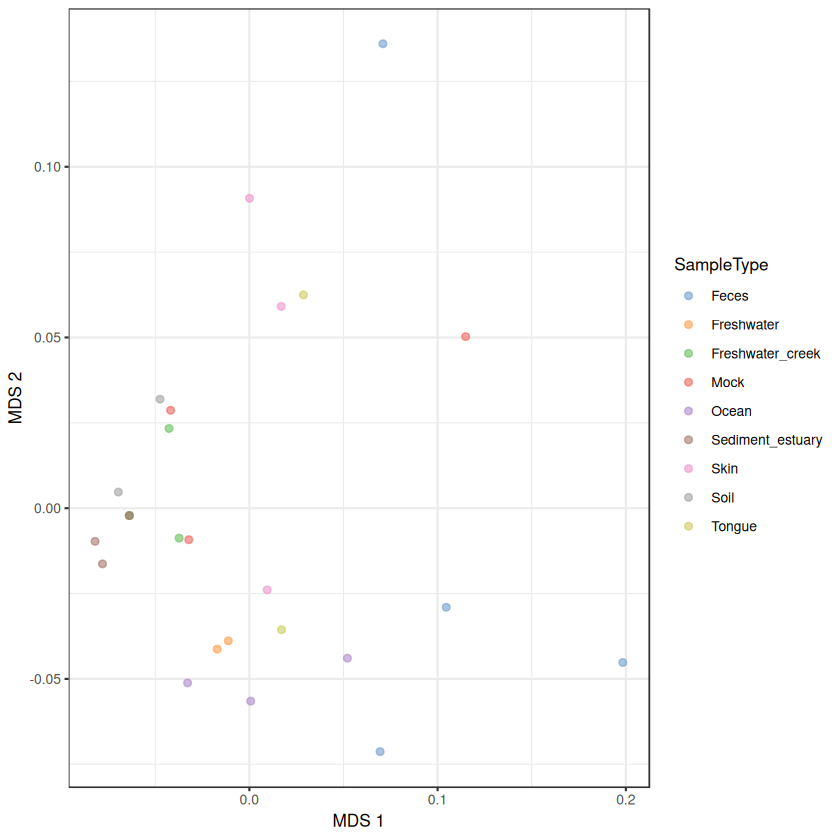

In [5]:
tse <- runMDS(
    tse,
    FUN = getDissimilarity,
    assay.type = "relabundance",
    method = "unifrac",
    tree = rowTree(tse),
    ntop = nrow(tse)
)

plotReducedDim(tse, "MDS", colour_by = "SampleType")

In [7]:
dim_red <- reducedDim(tse, "MDS")

sonify(
    x = dim_red[ , 1], y = dim_red[ , 2],
    waveform = "square", interpolation = "constant",
    pulse_len = 0.1, pulse_amp = 0.5,
    duration = 10, player = "mplayer",
)

## Phylogeny: the ultimate challenge

Phylogenetic trees lie at the core of microbiome data science. They represent the taxonomic similarity between microorganisms in a community. R doesn't really have a way to sonify or even textualise this plot, but someone figure out how it can be done and in principle it could be implemented on top of sonify or playitbyr (if this was still around).

The approach to sonify phylogenetic trees is described in [this article](https://hal.science/hal-01893569). Its basic idea is to go through the tree from the root to the tips and produce a sound every time a branch splits. By combining multiple chords, closely-related bugs will sound alike, wheareas distant bugs will sound very different.

This chart has title 'Phylogenetic Tree'.
It has x-axis '' with labels 0.0, 0.5 and 1.0.
It has y-axis '' with labels 50, 100 and 150.
There is a legend indicating colour is used to show edge_colour_by, with 5 levels:
Bacteroidetes shown as light blue colour, 
Cyanobacteria shown as brilliant orange colour, 
Firmicutes shown as brilliant yellowish green colour, 
Proteobacteria shown as strong reddish orange colour and 
Verrucomicrobia shown as light violet colour.
It has 4 layers.
Layer 1 is a segment graph that VI cannot process.
Layer 2 is a segment graph that VI cannot process.
Layer 3 is a segment graph that VI cannot process.
Layer 3 has alpha set to 1.
Layer 4 is a segment graph that VI cannot process.
Layer 4 has alpha set to 1.

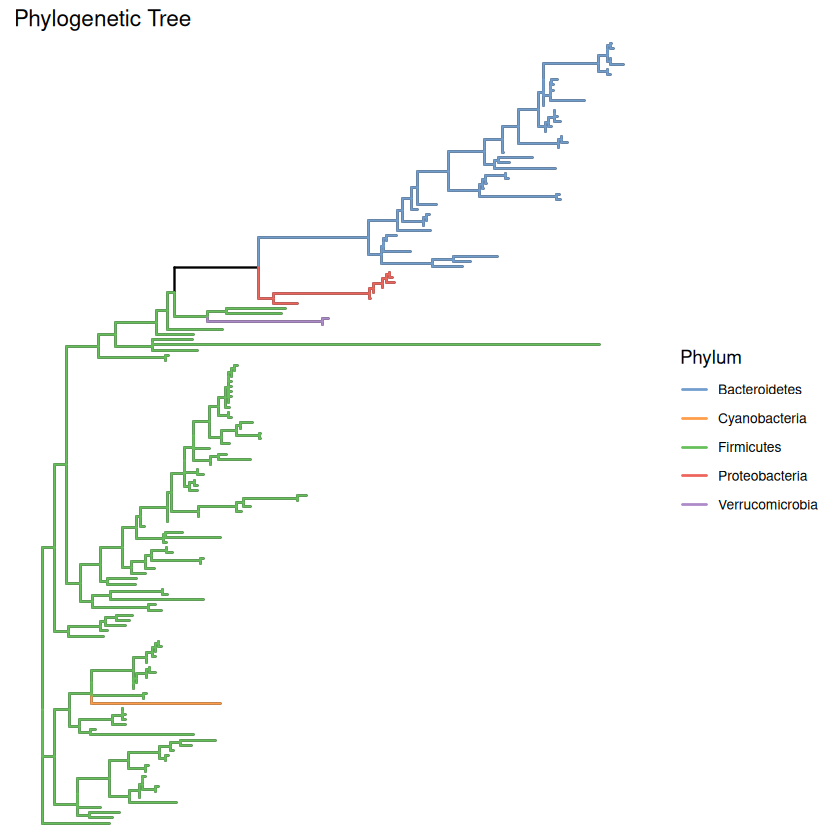

In [7]:
data("Tengeler2020", package = "mia")
tse <- Tengeler2020

p <- plotRowTree(
    tse,
    layout = "rectangular",
    edge_colour_by = "Phylum"
)

p + ggtitle("Phylogenetic Tree")

In [ ]:
# sonify() How???

## Additional Resources

- [Accessible Data Science for the Blind Using R](https://jooyoungseo.com/post/ds4blind/)
- [Microbiome turned DJ: Biota Beats](https://biotabeats.org/visualization.html)
- [Orchestrating Microbiome Analysis with Bioconductor](https://microbiome.github.io/OMA/)
- [BiliBili Tutorial on Phylogeny Sonification](https://www.bilibili.com/video/BV1ydxPeGEok/?buvid=YF4A73FDB2A6D554425BAF43A0A82915397A&from_spmid=search.search-result.0.0&is_story_h5=false&mid=HbSPY7IrFHktyJUZi%2BLvQQ%3D%3D&plat_id=116&share_from=ugc&share_medium=iphone_i&share_plat=ios&share_session_id=9C95499E-B69B-44E4-995D-9EA3392F704A&share_source=COPY&share_tag=s_i&spmid=united.player-video-detail.0.0&timestamp=1727491843&unique_k=PIyokrA&up_id=1619965160)